In [151]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from matplotlib.ticker import FuncFormatter, LogFormatter, LogLocator

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presion atmosferica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]

## DEFINICION DE FUNCIONES

# Funcion para formatear los ticks
def format_func(value, tick_number, decimals):
    return f'{value:.{decimals}f}'

def format_x_ticks(value, tick_number):
    if value < 1e-3:
        return f'{value:.1e}'  # Notacion cientifica para valores muy pequenos
    elif value < 0.1:
        return f'{value:.3f}'  # Tres decimales para valores pequenos
    else:
        return f'{value:.2f}'  # Dos decimales para otros valores

def setup_subplot(ax, im, xlabel, ylabel, letter):
    ax.set_xlabel(xlabel, fontsize=26)
    ax.set_ylabel(ylabel, fontsize=26, rotation=90)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    # Ajustar el limite superior del eje y para la grafica 'd'
    if letter == 'd':
        ax.set_ylim(1e-8, 1e2)
    else:
        ax.set_ylim(1e-8, 1e8)
    
    ax.set_xlim(0.3, 0.8)
    
    vmin, vmax = im.get_clim()
    ticks = np.linspace(vmin, vmax, 4)
    
    cbar = fig.colorbar(im, ax=ax, ticks=ticks)
    cbar.ax.tick_params(labelsize=26)
    
    if letter in 'ab':
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: f'{value:.0f}'))
    elif letter in 'cf':
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 2)))
    else:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 1)))
    
    color = 'black' if letter in 'abcd' else 'white'
    ax.text(0.05, 0.95, f'({letter})', transform=ax.transAxes, 
            ha='left', va='top', fontsize=26, color=color)
   
    ax.tick_params(axis='both', which='major', labelsize=26)
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.xaxis.set_tick_params(which='both', labelsize=26)
    
    ax.figure.canvas.draw()

def calculate_parameters(delta_T, D, L):
    T_w = T_a + delta_T
    h = 1.42 * (delta_T/L)**(1/4)
    phi = 1 / (beta * delta_T)
    Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T / h**2
    Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h)
    LAMBDA = L/D
    return phi, Ri, Ra, LAMBDA, h

def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v, max_iter  # Devuelve el último valor y el número máximo de iteraciones si no converge

# Calculo de la distribución espacial de thetas_star
def theta_estrella(eta, LAMBDA, v_e):
    a = LAMBDA / v_e
    return 1 - np.exp(-a * eta)

# Calculo de theta_star en eta = 1
def theta_star(LAMBDA, v_e):
    a = LAMBDA / v_e
    return 1 - np.exp(-a)


In [152]:
# Definir dimensiones de la tuberia
D = 20
L = 100

temperaturas = np.array([10, 500])
LAMBDA_extremos = [1, 10**3]
phi_extremos = 1 / (beta * temperaturas)
Ri_extremos = 2 * rho_0**2 * g * beta * L * Cp**2 * temperaturas / 1.42 * ((temperaturas/L)**(1/4))*2 

resolucion = 500

# Definir los rangos para los ejes
phi_range = np.linspace(phi_extremos[0], phi_extremos[1], resolucion)
LAMBDA_range = np.linspace(LAMBDA_extremos[0], LAMBDA_extremos[1], resolucion)
Ri_range = np.linspace(Ri_extremos[0], Ri_extremos[1], resolucion)

LAMBDA_cte = 10
Ri_cte = 10**2
Ra_cte = 10**6

# Define a safe exponential function
def safe_exp(x):
    try:
        return np.exp(x) if x < 700 else np.inf
    except:
        return np.inf

# Define functions
def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - safe_exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + LAMBDA/v)*safe_exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        try:
            v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
            if abs(v_new - v) < tol:
                return v_new
            v = v_new
        except:
            return np.nan
    return np.nan  # Return NaN if it doesn't converge

def calculate_theta(LAMBDA, v):
    return 1 - safe_exp(-LAMBDA/v)

# Initialize matrices
v_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
v_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))

theta_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
theta_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))

# Fill matrices
for i in range(resolucion):
    for j in range(resolucion):
        try:
            # LAMBDA and phi variables
            v = newton_raphson(phi_range[j], Ri_cte, Ra_cte, LAMBDA_range[i])
            v_norm = v 
            v_lambda_phi[i, j] = v
            theta_lambda_phi[i, j] = calculate_theta(LAMBDA_range[i], v)
            
            # Ri and phi variables
            v = newton_raphson(phi_range[j], Ri_range[i], Ra_cte, LAMBDA_cte)
            v_Ri_phi[i, j] = v
            theta_Ri_phi[i, j] = calculate_theta(LAMBDA_cte, v)
            
        except:
            print(f"Error at i={i}, j={j}")
            v_lambda_phi[i, j] = np.nan
            theta_lambda_phi[i, j] = np.nan
            v_Ri_phi[i, j] = np.nan
            theta_Ri_phi[i, j] = np.nan

print("Matrices created successfully.")



/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_3698/2064350651.py:39: RuntimeWarning: invalid value encountered in scalar divide
  v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)


Matrices created successfully.


In [153]:
# Calcular datos para la gráfica c (v_e)
Ri_range_new = np.logspace(2, 6, 50)
LAMBDA_range_new = np.logspace(0, 2, 50)
Ri_mesh, LAMBDA_mesh = np.meshgrid(Ri_range_new, LAMBDA_range_new)
v_e_mesh = np.zeros_like(Ri_mesh)

for i in range(Ri_mesh.shape[0]):
    for j in range(Ri_mesh.shape[1]):
        Ri = Ri_mesh[i,j]
        LAMBDA = LAMBDA_mesh[i,j]
        phi = 0.01
        Ra = 1e5
        v_e_mesh[i,j] = newton_raphson(phi, Ri, Ra, LAMBDA)

# Calcular datos para la gráfica f (theta_star)
theta_star_mesh = np.zeros_like(Ri_mesh)
for i in range(Ri_mesh.shape[0]):
    for j in range(Ri_mesh.shape[1]):
        Ri = Ri_mesh[i,j]
        LAMBDA = LAMBDA_mesh[i,j]
        # Usamos valores fijos para phi y Ra
        phi = 0.01
        Ra = 1e5
        v_e = newton_raphson(phi, Ri, Ra, LAMBDA)
        theta_star_mesh[i,j] = theta_star(LAMBDA, v_e)

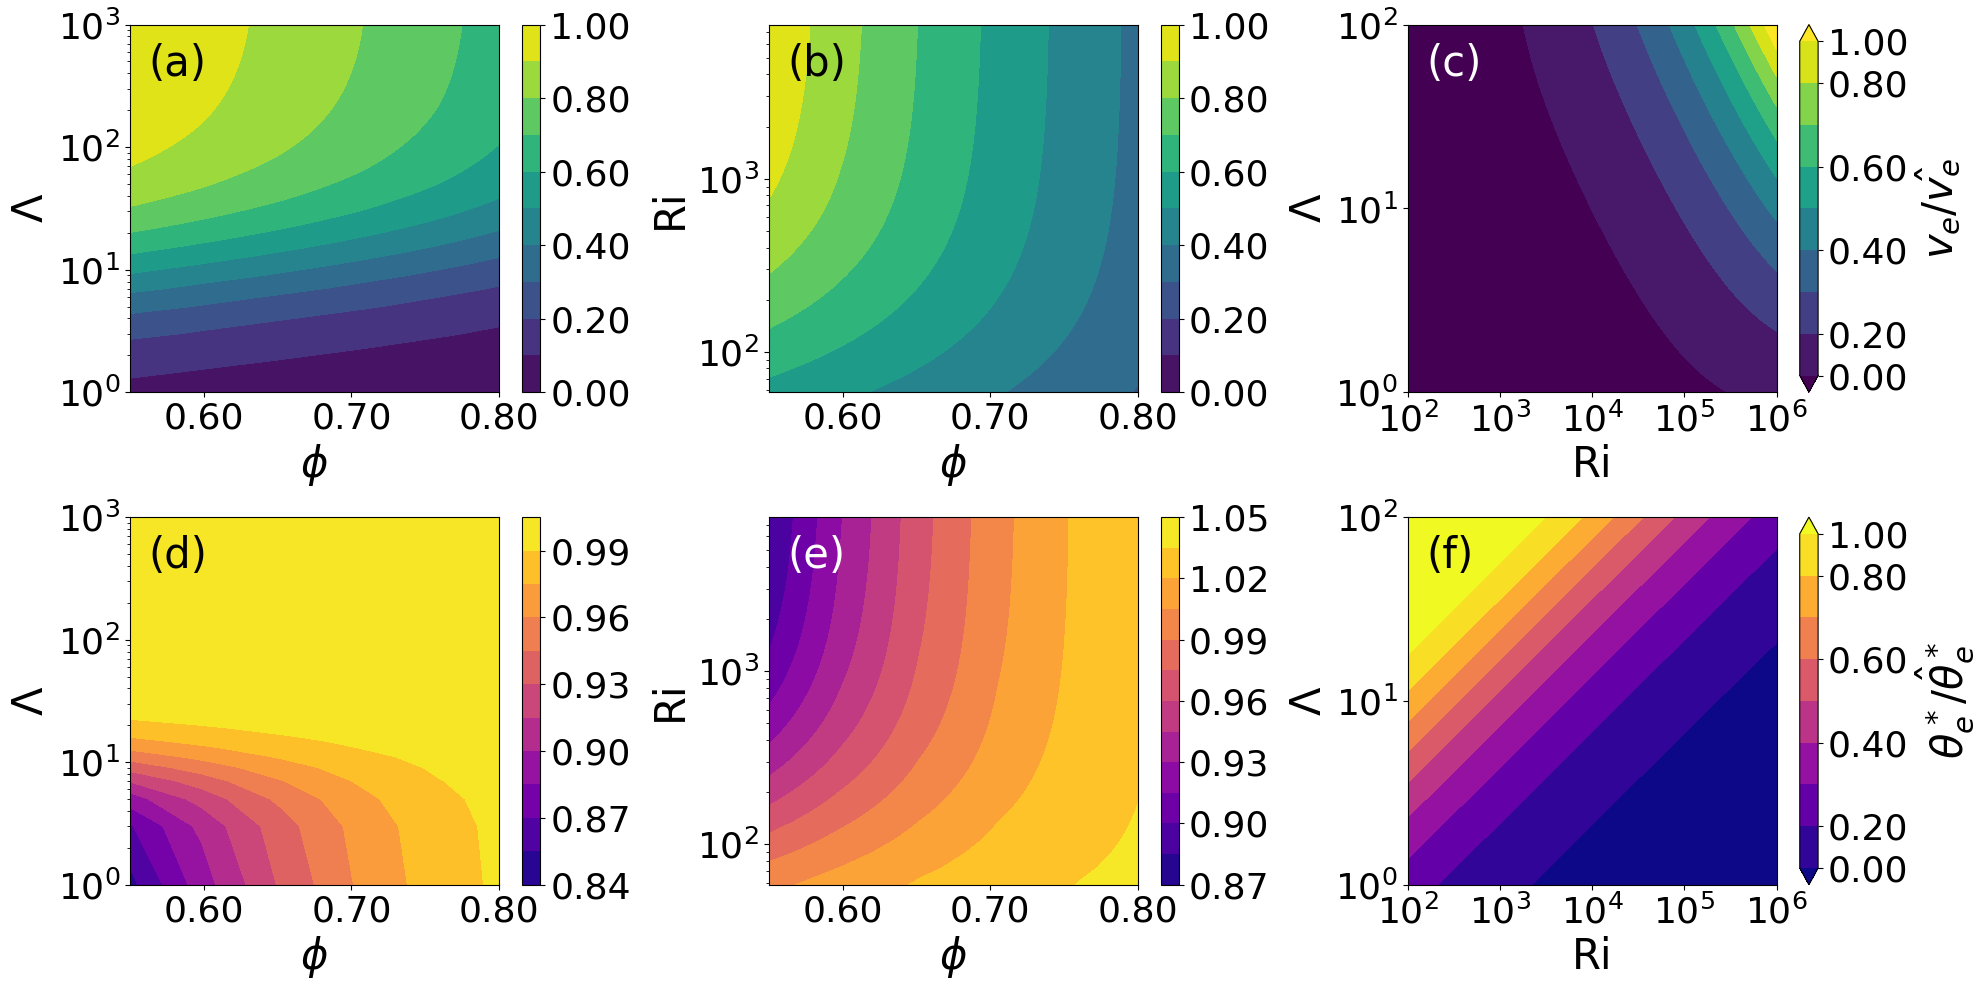

In [154]:
# Crear una figura con 6 subplots (2 filas, 3 columnas)
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Función para formatear la barra de color
def format_colorbar(value, tick_number):
    return f'{value:.2f}'

# Modifica la función setup_subplot para manejar las nuevas gráficas:
def setup_subplot(ax, im, xlabel, ylabel, letter):
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30, rotation=90)
    
    if letter in ['c', 'f']:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        x_ticks = np.arange(2, 7, 1)
        y_ticks = np.arange(0, 3, 1)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels([f'$10^{{{int(tick)}}}$' for tick in x_ticks], fontsize=30)
        ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in y_ticks], fontsize=30)
    else:
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.set_xlim(0.55, 0.8)
        ax.set_ylim(min(y_range), max(y_range))
        ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    
    # Ajustar la cantidad de ticks
    if letter in ['c', 'f']:
        cbar = fig.colorbar(im, ax=ax, ticks=np.linspace(0, 1, 6))  # Ajusta el número de ticks
    else:
        cbar = fig.colorbar(im, ax=ax)
    
    cbar.ax.tick_params(labelsize=26)
    
    if letter == 'c':
        cbar.set_label(r'$v_e / \hat{v_e}$', fontsize=30)
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_colorbar))
    elif letter == 'f':
        cbar.set_label(r'$\theta_e^* / \hat{\theta}_e^*$', fontsize=30)
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_colorbar))
    else:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_colorbar))

    color = 'white' if letter in 'ce' else 'black'
    ax.text(0.05, 0.95, f'({letter})', transform=ax.transAxes, 
            ha='left', va='top', fontsize=30, color=color)
   
    ax.tick_params(axis='both', which='major', labelsize=26)

# Modifica el bucle de creación de subplots:
# Lista de parámetros para cada subplot
subplot_params = [
    (v_lambda_phi / max(v_lambda_phi[:,-1]), r'$\phi$', r'$\Lambda$', LAMBDA_range, phi_range),
    (v_Ri_phi / max(v_Ri_phi[:,-1]), r'$\phi$', 'Ri', Ri_range, phi_range),
    (v_e_mesh / max(v_e_mesh[:,-1]), 'Ri', r'$\Lambda$', LAMBDA_range_new, Ri_range_new),
    (theta_lambda_phi/ max(theta_lambda_phi[:,-1]), r'$\phi$', r'$\Lambda$', LAMBDA_range, phi_range),
    (theta_Ri_phi / max(theta_Ri_phi[:,-1]), r'$\phi$', 'Ri', Ri_range, phi_range),
    (theta_star_mesh /max(theta_star_mesh[:,0]), 'Ri', r'$\Lambda$', LAMBDA_range_new, Ri_range_new)
]

# Crear subplots
for i, (data, xlabel, ylabel, y_range, x_range) in enumerate(subplot_params):
    row = i // 3
    col = i % 3
    letter = chr(97 + i)  # 'a' to 'f'
    cmap = 'viridis' if i < 3 else 'plasma'
    
    if letter in ['c', 'f']:
       X, Y = np.meshgrid(np.log10(x_range), np.log10(y_range))
       im = axs[row, col].contourf(X, Y, data, levels=10, cmap=cmap, extend='both')
    else:
        im = axs[row, col].contourf(x_range, y_range, data, levels=10, cmap=cmap)
    
    setup_subplot(axs[row, col], im, xlabel, ylabel, letter)

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [155]:
# Calcular los valores máximos
max_v_lambda_phi = np.max(v_lambda_phi[:,-1])
max_v_Ri_phi = np.max(v_Ri_phi[:,-1])
max_v_e_mesh = np.max(v_e_mesh)
max_theta_lambda_phi = np.max(theta_lambda_phi[:,-1])
max_theta_Ri_phi = np.max(theta_Ri_phi[:,-1])
max_theta_star_mesh = np.max(theta_star_mesh)


# Imprimir los valores máximos
print('Para escalar la velocidad entre 0 y 1, tomo el valor máximo:')
print('Para a y b:', round(max_v_lambda_phi,2), round(max_v_Ri_phi,2))
print('Para c:', round(max_v_e_mesh,2))
print('Para escalar la temperatura entre 0 y 1, tomo el valor máximo:')
print('Para a y b:', round(max_theta_lambda_phi,2), round(max_theta_Ri_phi,2))
print('Para c:', round(max_theta_star_mesh,2))

Para escalar la velocidad entre 0 y 1, tomo el valor máximo:
Para a y b: 6.7 5.33
Para c: 344.44
Para escalar la temperatura entre 0 y 1, tomo el valor máximo:
Para a y b: 1.0 0.96
Para c: 1.0
